# Detecting Early Fire Indicator Patterns in Multivariate-Time Series Based on a Multi-Sensor Node Network

## Libaries

In [1]:
# Standard libaries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()   
import os
from pathlib import Path
import datetime
from sklearn.utils import resample
import re
from datetime import datetime
from datetime import timedelta
import math

# skLearn
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

#Sktime
from sktime.classification.kernel_based import RocketClassifier
from sktime.datatypes import check_raise
from sktime.datatypes import mtype
from sktime.datatypes import check_is_mtype
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.transformations.series.summarize import SummaryTransformer
from sktime.datatypes import convert_to
from sktime.datatypes import convert
from sktime.transformations.panel.rocket import MiniRocketMultivariate

# Additional
import matplotlib.dates as mdates
import time # to claculate the runtime of models
from pathlib import Path 

# SHAP Explanation
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Get the current directory
current_dir = os.getcwd()
data_path = os.path.join(current_dir, 'data')

In [3]:
directory_export = os.path.join(current_dir, 'export/network')

# Check if the directory exists
if not os.path.exists(directory_export):
    # Create the directory if it doesn't exist
    os.makedirs(directory_export)

## Variables

In [4]:
# Define Features
FEATURES_STATIC = ['CO_Room',
                    'H2_Room',
                    'VOC_Room_RAW',
                    'PM05_Room',
                    'PM10_Room',
                   ]

# Combine to one FEATURES list
FEATURES = FEATURES_STATIC

In [5]:
# Define Sensornodes
sensornodes_list = [8,
                    9,
                    10,
                    11,
                    12,
                    13,
                    14,
                    15,
                    16
                   ]

## Data Preparation

In [6]:
# Import data
# Construct the absolute path to the data file
file_name = 'indoor_fire_detection_multisensornodes_dataset_preprocessed.csv'
data_file_path = os.path.join(data_path, file_name)

X_t = pd.read_csv(data_file_path, index_col=0)

In [7]:
# Convert 'Date' column to int64 data type
X_t['date'] = X_t['date'].astype('int64')

In [8]:
# Use only number of sensornode instead of string name
X_t['Sensor_ID'] = X_t['Sensor_ID'].str[-2:].astype(int) # anpassen auf Zwei Stellen!!

In [9]:
# Drop non relevant labels
X_t = X_t.drop(columns = ['scenario_label', 
                          'progress_label', 
                          'anomaly_label', 
                          'ternary_label', 
                          #'Motion_Room', 
                          #'Motion_Room_Trend'
                         ])

In [10]:
# Rename columns
X_t = X_t.rename(columns={"date": "timepoints"})

In [11]:
# Transform X_t in mtype="pd-multiindex" format for sktime
# doc.: https://github.com/sktime/sktime/blob/main/examples/AA_datatypes_and_datasets.ipynb

X_t.set_index(['interval_label','Sensor_ID', 'timepoints'], inplace=True)

X_t = X_t.groupby(level=[0,1,2], sort=True).sum()

X_t['timepoints'] = X_t.groupby(['interval_label','Sensor_ID']).cumcount()
X_t['timepoints'] = X_t['timepoints'].apply(lambda x: x*10)

X_t = X_t.set_index('timepoints', append=True)
X_t = X_t.droplevel(2)

# define data columns
data_columns = FEATURES

# Pivot the DataFrame to have Sensor_ID levels as columns
X_t_pivot = X_t.pivot_table(index=['interval_label', 'timepoints'], columns='Sensor_ID', values=data_columns)

# Flatten the column MultiIndex
X_t_pivot.columns = [f"{col[0]}_{col[1]}" for col in X_t_pivot.columns]

# Give fire label if at least one sensornode in that interval takes "fire" label
label_column_df = X_t.groupby('interval_label')['fire_label'].apply(lambda x: 'Fire' in x.values).map({True: 'Fire', False: 'NoFire'})

# add flattend fire label to df
X_t_pivot_merged = X_t_pivot.merge(label_column_df, how='left', left_on='interval_label', right_index=True)

In [12]:
# Define encoding and decoding of Label column
# Encode string labels to integers
label_mapping = {"NoFire": 0, "Fire": 1} # do the label encoding by yourself

# Define a function to map labels using the dictionary
def map_labels(label):
    return label_mapping[label]

# Inverse mapping dictionary
inverse_label_mapping = {0: "NoFire", 1: "Fire"}

# Use numpy.vectorize to apply the mapping function element-wise
X_t_pivot_merged['fire_label'] = np.vectorize(map_labels)(X_t_pivot_merged['fire_label'])

In [13]:
X_t_pivot_merged

CO_Room_8  CO_Room_9  CO_Room_10  CO_Room_11  \
interval_label timepoints                                                 
0              0               -0.25      -0.43        0.15       -0.08   
               10              -0.25      -0.43        0.15       -0.08   
               20              -0.25      -0.43        0.15       -0.08   
               30              -0.28      -0.30        0.14        0.03   
               40              -0.24      -0.22        0.19        0.07   
...                              ...        ...         ...         ...   
3761           40               4.61       3.22        2.27        2.55   
               50               4.63       3.31        2.36        2.67   
               60               4.64       3.26        2.37        2.77   
               70               4.64       3.29        2.54        2.79   
               80               4.62       3.31        2.50        2.76   

                           CO_Room_12  CO_Room_13  CO_Room_14  CO_Room_15  \
interval_label timepoints                                                   
0              0                -0.16       -0.03        0.08       -0.08   
               10               -0.16       -0.03        0.08       -0.08   
               20               -0.16       -0.03        0.08       -0.03   
               30               -0.13        0.04        0.10       -0.07   
               40               -0.09       -0.07        0.00       -0.11   
...                               ...         ...         ...         ...   
3761           40                2.71        2.04        2.10        4.93   
               50                2.73        2.08        2.26        4.99   
               60                2.75        2.09        2.28        5.01   
               70                2.78        2.18        2.21        4.97   
               80                2.81        2.17        2.27        4.95   

                           CO_Room_16  H2_Room_8  ...  VOC_Room_RAW_8  \
interval_label timepoints                         ...                   
0              0                 0.18       0.00  ...             0.5   
               10                0.18       0.00  ...             0.5   
               20                0.01       0.00  ...             0.5   
               30               -0.08       0.05  ...             0.5   
               40               -0.03       0.06  ...             0.5   
...                               ...        ...  ...             ...   
3761           40                3.70       0.29  ...            15.4   
               50                3.76       0.27  ...            15.1   
               60                3.73       0.28  ...            15.2   
               70                3.74       0.31  ...            15.3   
               80                3.66       0.31  ...            15.4   

                           VOC_Room_RAW_9  VOC_Room_RAW_10  VOC_Room_RAW_11  \
interval_label timepoints                                                     
0              0                      0.5              0.6              0.5   
               10                     0.5              0.6              0.5   
               20                     0.5              0.6              0.5   
               30                     0.5              0.6              0.5   
               40                     0.5              0.6              0.5   
...                                   ...              ...              ...   
3761           40                    16.1             15.8             14.9   
               50                    16.0             15.9             14.6   
               60                    15.9             16.1             14.4   
               70                    15.7             16.4             14.7   
               80                    15.8             16.6             14.5   

                           VOC_Room_RAW_12  VOC_Room_RAW_13  VOC_Room_R

## Define model function

In [14]:
# Define Explanation Function
def mvts_shap(X_train, X_test, y_train, y_test, X_reference_negative, X_reference_positive):
    
    i, j, k = X_train.shape # i = intervals, j = features, k = timepoints per interval
    u, v, w = X_test.shape
    l, s, t = X_reference_negative.shape 
    
    X_train_flat = X_train.reshape(i, j*k)
    X_reference_negative_flat = X_reference_negative.reshape(l, s*t) # reshape selected background intervals
    X_reference_positive_flat = X_reference_positive.reshape(l, s*t)
    X_reference_positive_and_negative_flat = np.concatenate((X_reference_negative_flat, X_reference_positive_flat), axis=0)
    
    def reshaper(inner_tensor):
        return inner_tensor.reshape(inner_tensor.shape[0], j, k)

    def inv_reshaper(inner_tensor):
        return inner_tensor.reshape(inner_tensor.shape[0], j*k)

    param = {
            'objective': 'binary:logistic',
            'tree_method': 'hist',
            'eval_metric': 'logloss',
            'seed': 888,
            'n_estimators': 500
           }

    pipe = Pipeline([
        ('reshaper_t', FunctionTransformer(reshaper, inverse_func=inv_reshaper)),
        ('tabulariser', MiniRocketMultivariate(num_kernels=10000, n_jobs= -1, random_state=1837)), #(num_kernels=588, n_jobs=-1, random_state=1837)
        ('scaler', StandardScaler()), #'scaler', StandardScaler() # 'scaler', MinMaxScaler()
        ('bst', xgb.XGBClassifier(**param))
    ])
    
    pipe.fit(X_train_flat, y_train)
    
    # Take n random samples from referenz data
    masker = shap.maskers.Independent(X_reference_positive_and_negative_flat, 6) # number defines the amount of intervals to be considered
    #X_reference_negative_flat #X_reference_positive_flat #3
    
    # fixed background dataset with the same shape as X_train_flat_summary
    fixed_background_data = np.full_like(masker.data, 1000)
    
    # Define Explainer
    explainer = shap.KernelExplainer(pipe.predict_proba, masker.data)

    # Explanation on 0 to n = sample_size intervals
    sample_size =  u 
    sample_idx = np.arange(sample_size)
    
    # Derive SHAP explanations Explainer
    shap_output = explainer.shap_values(X_test[sample_idx, :, :].reshape(sample_size, v * w))    
    shap_tensor_no_fire = shap_output[0].reshape(sample_size, v, w) #ACHTUNG: [0] muss encoded dem gewünschten Label entsprechen!
    shap_tensor_fire = shap_output[1].reshape(sample_size, v, w) 
    base_value_shap = explainer.expected_value[1]
    
    # Get the model's predictions on the test data
    model_predictions_encoded = pipe.predict(X_test.reshape(u, v*w))
    
    # Get predict_proba on test data
    model_predict_proba = pipe.predict_proba(X_test.reshape(u, v*w))
    
    return shap_tensor_no_fire, shap_tensor_fire, model_predictions_encoded, model_predict_proba, base_value_shap

## Build model

### Train/ Test Split

In [15]:
train_test_data = X_t_pivot_merged.copy()

In [16]:
# Derive Train and hold-out (test) set
split_interval = 720

# Split Time Series into train and test based on split interval
df_train = train_test_data.loc[train_test_data.index.get_level_values('interval_label') <= split_interval]
df_test = train_test_data.loc[train_test_data.index.get_level_values('interval_label') > split_interval]

In [17]:
# Derive X_train, X_test etc. 
feature_columns = train_test_data.columns.difference(['fire_label'])
# X_train
X_train = df_train[feature_columns]
# X_test
X_test = df_test[feature_columns]
# y_train
y_train = df_train['fire_label'].groupby('interval_label').first().to_numpy()
# y_test
y_test = df_test['fire_label'].groupby('interval_label').first().to_numpy()

## Build model

  0%|          | 0/3041 [00:00<?, ?it/s]

Scaler: NoScaling
max Shap value NoFire:  0.3467699276106778
min Shap value NoFire -0.2747002211879098
max Shap value Fire:  0.2747002154719949
min Shap value Fire -0.3467699201062535
Base SHAP Value (expected_value): 0.48274247350248817


Using the barplot function without specifying `order` is likely to produce an incorrect plot.


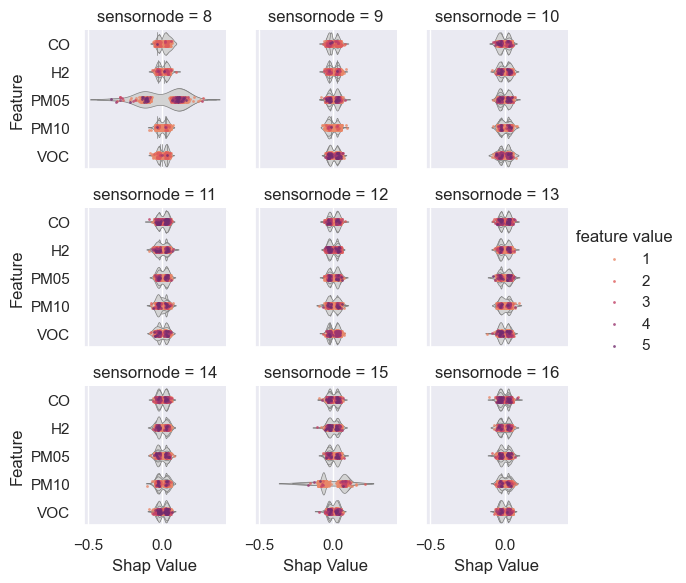

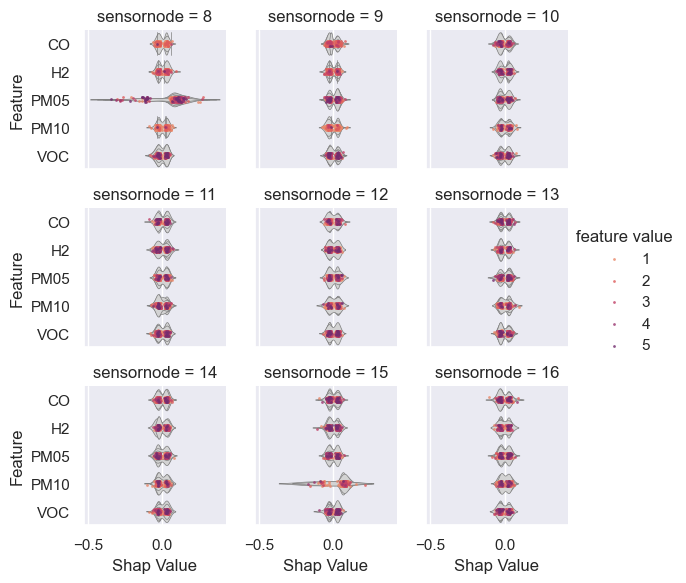

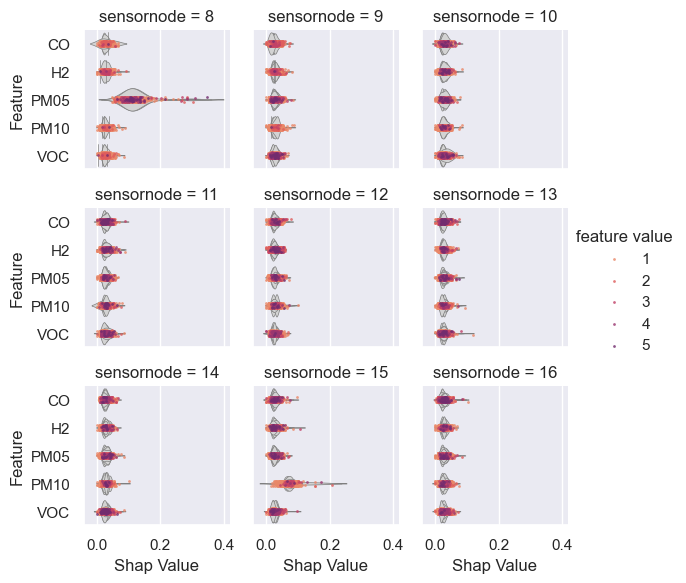

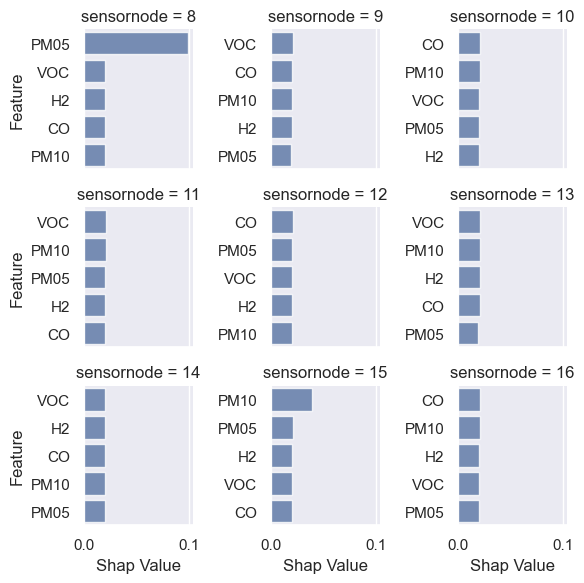

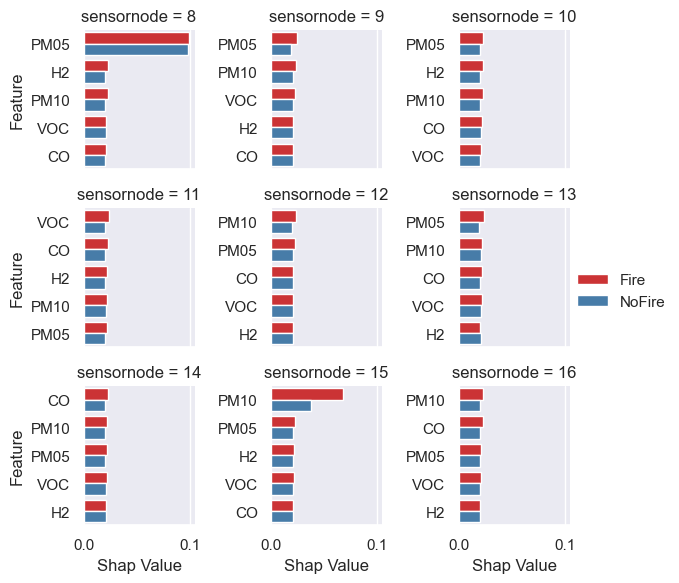

In [18]:
# Generate background referenz data for SHAP explanation
# Define number of intervals for shap referenz data
sample_size = 5

dfs_max_shap_values_fire = []
dfs_shap_mean = []

# Randomly select n rows where "NoFire" occurs in the "fire_label" column based on 'Interval_label'
# Find all intervals where 'fire_label' is 'NoFire' for each group 
selected_intervals_negative = list(df_train.loc[df_train['fire_label'] == 0].groupby(level='interval_label').groups.keys())
selected_intervals_positive = list(df_train.loc[df_train['fire_label'] == 1].groupby(level='interval_label').groups.keys())
# sample n intervals
selected_intervals_negative = np.random.choice(selected_intervals_negative, size=min(sample_size, len(selected_intervals_negative)), replace=False)
selected_intervals_positive = np.random.choice(selected_intervals_positive, size=min(sample_size, len(selected_intervals_positive)), replace=False)

# Scaling: static for train and test set, not per subsequence
# Define Scaler
dict_scaler = {'NoScaling': None,
#                'QuantileTransformer10': QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal'),
#                'QuantileTransformer20': QuantileTransformer(n_quantiles=20, random_state=0, output_distribution='normal'),
#                'QuantileTransformer30': QuantileTransformer(n_quantiles=30, random_state=0, output_distribution='normal'),
#                'QuantileTransformer5': QuantileTransformer(n_quantiles=5, random_state=0, output_distribution='normal'),
#                'QuantileTransformer4': QuantileTransformer(n_quantiles=4, random_state=0, output_distribution='normal'),
#                'QuantileTransformer50': QuantileTransformer(n_quantiles=50, random_state=0, output_distribution='normal'),
#                'RobustScaler': RobustScaler(),
#                'MaxAbsScaler': MaxAbsScaler(),
#                'PowerTransformer': PowerTransformer(),
#                'Normalizer': Normalizer(),
#                'StandardScaler': StandardScaler(),
#                'MinMaxScaler': MinMaxScaler()
              }

for scaler_name, scaler_instance in dict_scaler.items():

    if scaler_instance is not None:
        # Define scaler
        scaler = scaler_instance

        # Fit the scaler on X_train
        scaler.fit(X_train)

        # Transform X_train and X_test separately
        X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

        # Use pd.IndexSlice to select rows based on the array of indexes
        X_background_shap_negative_scaled = X_train_scaled.loc[pd.IndexSlice[selected_intervals_negative, :], :]
        X_background_shap_positive_scaled = X_train_scaled.loc[pd.IndexSlice[selected_intervals_positive, :], :]

        # Transform X_train etc. into 3D numpy array
        X_train_3d_scaled = convert_to(X_train_scaled, to_type="numpy3D")
        X_test_3d_scaled = convert_to(X_test_scaled, to_type="numpy3D")
        X_reference_negative_3d_scaled = convert_to(X_background_shap_negative_scaled, to_type="numpy3D")
        X_reference_positive_3d_scaled = convert_to(X_background_shap_positive_scaled, to_type="numpy3D")                

        # apply mvts_shap function to data
        shap_values_no_fire, shap_values_fire, y_pred_encoded, pred_proba, base_value_shap = mvts_shap(X_train_3d_scaled,
                                                                                                       X_test_3d_scaled,
                                                                                                       y_train,
                                                                                                       y_test,
                                                                                                       X_reference_negative_3d_scaled,
                                                                                                       X_reference_positive_3d_scaled
                                                                                                      )

    else:

        # Use pd.IndexSlice to select rows based on the array of indexes
        X_background_shap_negative = X_train.loc[pd.IndexSlice[selected_intervals_negative, :], :]
        X_background_shap_positive = X_train.loc[pd.IndexSlice[selected_intervals_positive, :], :]

        # Transform X_train etc. into 3D numpy array (unscaled)
        X_train_3d = convert_to(X_train, to_type="numpy3D")
        X_test_3d = convert_to(X_test, to_type="numpy3D")
        X_reference_negative_3d = convert_to(X_background_shap_negative, to_type="numpy3D")
        X_reference_positive_3d = convert_to(X_background_shap_positive, to_type="numpy3D")

        # apply mvts_shap function to data
        shap_values_no_fire, shap_values_fire, y_pred_encoded, pred_proba, base_value_shap = mvts_shap(X_train_3d,
                                                                                                       X_test_3d,
                                                                                                       y_train,
                                                                                                       y_test,
                                                                                                       X_reference_negative_3d,
                                                                                                       X_reference_positive_3d
                                                                                                      ) 
        
    # Direct Print outs
    print('Scaler:', scaler_name)
    print('max Shap value NoFire: ', shap_values_no_fire.max())
    print('min Shap value NoFire', shap_values_no_fire.min())
    print('max Shap value Fire: ', shap_values_fire.max())
    print('min Shap value Fire', shap_values_fire.min())
    print('Base SHAP Value (expected_value):', base_value_shap)
    
    # Inverse transform the encoded labels to decode them
    y_pred = np.vectorize(inverse_label_mapping.get)(y_pred_encoded)

    # Retransform from 3D array to multiindex df
    # convert
    df_shap_values_no_fire = convert(shap_values_no_fire, from_type="numpy3D", to_type="pd-multiindex")
    df_shap_values_fire = convert(shap_values_fire, from_type="numpy3D", to_type="pd-multiindex")             
    # Get column names based on original df
    columns_names = X_train.columns.tolist()
    # Rename the columns
    df_shap_values_no_fire.columns = columns_names
    df_shap_values_fire.columns = columns_names
    # Multiply the values in the second index level by 10
    df_shap_values_no_fire.index = df_shap_values_no_fire.index.set_levels(df_shap_values_no_fire.index.levels[1] * 10, level=1)
    df_shap_values_fire.index = df_shap_values_fire.index.set_levels(df_shap_values_fire.index.levels[1] * 10, level=1)
    # rename index
    df_shap_values_no_fire.index = df_shap_values_no_fire.index.set_names('interval_label', level=0)
    df_shap_values_fire.index = df_shap_values_fire.index.set_names('interval_label', level=0)
    
    # speichere die max_shap_values pro feature und Sensorknoten für fire class
    df_max_shap_values_fire_temp = pd.DataFrame(df_shap_values_fire.max()).reset_index().rename(columns={0: 'shap_value_fire_max', 'index': 'feature'})
    dfs_max_shap_values_fire.append(df_max_shap_values_fire_temp)
    

    # Add model Predictions to df_test 
    # Convert the NumPy array to a pandas DataFrame
    y_pred_df = pd.DataFrame({'model_prediction': y_pred})

    # Add a second column containing the interval_label
    y_pred_df['interval_label'] = df_test.index.get_level_values('interval_label').unique()

    # Set 'index_column' as the index
    y_pred_df.set_index('interval_label', inplace=True)

    # Convert the DataFrame to a dictionary
    y_pred_dict = y_pred_df.to_dict(orient='dict')['model_prediction']

    # add model_prediction to df_test_export
    df_test_export = df_test.copy()
    df_test_export['model_prediction'] = df_test_export.index.get_level_values('interval_label').map(y_pred_dict)

    # encode the true label in df_test_export
    df_test_export['fire_label'] = np.vectorize(inverse_label_mapping.get)(df_test_export['fire_label'])

    # Reset Interval_label index so that it can be merged with df_shap_values
    # Calculate the offset to align df_2 with df_1
    offset = df_shap_values_no_fire.index.get_level_values('interval_label').min() - df_test_export.index.get_level_values('interval_label').min()
    # Adjust the index of df_2
    df_test_export.index = df_test_export.index.set_levels(df_test_export.index.levels[0] + offset, level=0)

    # Export df_test
    # Construct the absolute path to the data file
    file_name = f'df_test_elba_rocket_network_{scaler_name}.csv'
    data_file_path = os.path.join(directory_export, file_name)
    df_test_export.to_csv(data_file_path)

    # Export df_shap_values
    file_name = f'df_shap_values_elba_rocket_nofire_network_{scaler_name}.csv'
    data_file_path = os.path.join(directory_export, file_name)
    df_shap_values_no_fire.to_csv(data_file_path) 

    # Export df_shap_values
    file_name = f'df_shap_values_elba_rocket_fire_network_{scaler_name}.csv'
    data_file_path = os.path.join(directory_export, file_name)
    df_shap_values_fire.to_csv(data_file_path) 
    
    # Define SHAP Plots
    # Define column order for facetgrid plots
    col_order = ['8',
                 '9', 
                 '10',
                 '11',
                 '12',
                 '13',
                 '14',
                 '15',
                 '16']
    
    # summarize timepoints per interval by mean
    df_shap_values_fire_mean = df_shap_values_fire.copy()
    df_shap_values_fire_mean = df_shap_values_fire_mean.groupby(level='interval_label').mean()
    # write label for fire resp. no_fire intervals
    df_shap_values_fire_mean['fire_label'] = df_test_export.groupby(level='interval_label')['fire_label'].first() #'fire'
    
    # derive max absolute values by respecting the sign (fire and no_fire intervals)
    # create new df to derive indexes
    df_indexes = df_shap_values_fire.copy()
    # find indexes of maximum absolute value 
    df_indexes = df_indexes.groupby('interval_label').apply(lambda group: group.loc[:, group.columns != 'fire_label'].abs().idxmax())
    # replace indexes by shap values
    df_shap_values_fire_max_abs_sign = df_indexes.copy()
    for col in df_indexes.columns:
        df_shap_values_fire_max_abs_sign[col] = [df_shap_values_fire.loc[tuple(val), col] for val in df_indexes[col]]
    # replace indexes by measurement values
    df_measurement_values_fire_max_abs_sign = df_indexes.copy()
    for col in df_indexes.columns:
        df_measurement_values_fire_max_abs_sign[col] = [df_test_export.loc[tuple(val), col] for val in df_indexes[col]]
    # derive scaled measurement values for coloring feature size in plot
    columns_to_bin = df_measurement_values_fire_max_abs_sign.columns
    df_measurement_values_fire_max_abs_sign_scaled = df_measurement_values_fire_max_abs_sign.copy()
    # Define the number of bins (adjust as needed)
    num_bins = 5
    # Loop through each column and perform binning, scaling, and conversion to integers
    for column in columns_to_bin:
        # Create bins using cut
        df_measurement_values_fire_max_abs_sign_scaled[column] = pd.cut(df_measurement_values_fire_max_abs_sign_scaled[column], bins=num_bins, labels=False)
        # Scale the values to the range [0, 10]
        df_measurement_values_fire_max_abs_sign_scaled[column] = df_measurement_values_fire_max_abs_sign_scaled[column] * ((5 - 1) / (num_bins - 1)) + 1 
        # Convert scaled values to integers
        df_measurement_values_fire_max_abs_sign_scaled[column] = df_measurement_values_fire_max_abs_sign_scaled[column].astype(int)  
    # melt the scaled df in the same form as the shap value for plot
    df_measurement_values_fire_max_abs_sign_scaled_melted = pd.melt(df_measurement_values_fire_max_abs_sign_scaled, var_name='feature', value_name='size')
    df_measurement_values_fire_max_abs_sign_scaled_melted['sensornode'] = df_measurement_values_fire_max_abs_sign_scaled_melted['feature'].apply(lambda x: x.split('_')[-1])
    df_measurement_values_fire_max_abs_sign_scaled_melted['feature'] = df_measurement_values_fire_max_abs_sign_scaled_melted['feature'].apply(lambda x: x.split('_')[0])
    # melt shap values df
    df_melted = pd.melt(df_shap_values_fire_max_abs_sign, var_name='feature', value_name='shap_value')
    # swarmplot single node
    df_plot = df_melted.copy()
    df_plot['sensornode'] = df_plot['feature'].apply(lambda x: x.split('_')[-1])
    df_plot['feature'] = df_plot['feature'].apply(lambda x: x.split('_')[0])
    # add feature size to df plot
    # df1.merge(df2, how='inner', on='a') # (alternative)
    list_feature_sizes = df_measurement_values_fire_max_abs_sign_scaled_melted['size'].to_list()
    df_plot['size'] = list_feature_sizes
    # Create a FacetGrid
    feature_order = ['CO','H2','PM05','PM10','VOC']
    g = sns.FacetGrid(data=df_plot, col="sensornode", col_wrap=3, height=2, col_order=col_order, hue = 'size', palette="flare") #, hue = 'size'
    # Map a swarmplot to the FacetGrid
    g.map(sns.stripplot, "shap_value", "feature", orient="h", alpha=.8, s=2, order=feature_order) #swarmplot
    g.map(sns.violinplot, "shap_value", "feature", inner=None, color="lightgray", linewidth=0.5, order=feature_order)
    # Set axis labels and adjust plot layout
    # g.add_legend(title = 'feature value')
    # Customize x-axis labels for every subplot
    # g.set_xticklabels()
    # Add legend
    g.add_legend(title='feature value')
    # axes titles
    g.set_axis_labels("Shap Value", "Feature")
    # Save the plot to a PNG file
    file_name = f'shap_values_max_abs_sign_network_swarmplot_{scaler_name}.png'
    # Create the file path using an f-string
    file_path = os.path.join(directory_export, file_name)
    plt.savefig(file_path)
    
    
    # derive max absolute SHAP values by respecting the sign (only fire intervals)
    # create new df to derive indexes
    df_indexes = df_shap_values_fire.copy()
    # add fire_label to select only fire intervals
    df_indexes['fire_label'] = df_test_export['fire_label'].to_list()[:len(df_shap_values_fire)]
    # select only fire intervals
    df_indexes = df_indexes.loc[df_indexes.fire_label == 'Fire'] # Fire
    # find indexes of maximum absolute value 
    df_indexes = df_indexes.groupby('interval_label').apply(lambda group: group.loc[:, group.columns != 'fire_label'].abs().idxmax())
    # replace indexes by shap values
    df_shap_values_fire_max_abs_sign = df_indexes.copy()
    for col in df_indexes.columns:
        df_shap_values_fire_max_abs_sign[col] = [df_shap_values_fire.loc[tuple(val), col] for val in df_indexes[col]]
    # replace indexes by measurement values
    df_measurement_values_fire_max_abs_sign = df_indexes.copy()
    for col in df_indexes.columns:
        df_measurement_values_fire_max_abs_sign[col] = [df_test_export.loc[tuple(val), col] for val in df_indexes[col]]
    # derive scaled measurement values for coloring feature size in plot
    columns_to_bin = df_measurement_values_fire_max_abs_sign.columns
    df_measurement_values_fire_max_abs_sign_scaled = df_measurement_values_fire_max_abs_sign.copy()
    # Define the number of bins (adjust as needed)
    num_bins = 5
    # Loop through each column and perform binning, scaling, and conversion to integers
    for column in columns_to_bin:
        # Create bins using cut
        df_measurement_values_fire_max_abs_sign_scaled[column] = pd.cut(df_measurement_values_fire_max_abs_sign_scaled[column], bins=num_bins, labels=False)
        # Scale the values to the range [0, 10]
        df_measurement_values_fire_max_abs_sign_scaled[column] = df_measurement_values_fire_max_abs_sign_scaled[column] * ((5 - 1) / (num_bins - 1)) + 1 # (5 / (num_bins - 1))
        # Convert scaled values to integers
        df_measurement_values_fire_max_abs_sign_scaled[column] = df_measurement_values_fire_max_abs_sign_scaled[column].astype(int)  
    # melt the scaled df in the same form as the shap value for plot
    df_measurement_values_fire_max_abs_sign_scaled_melted = pd.melt(df_measurement_values_fire_max_abs_sign_scaled, var_name='feature', value_name='size')
    df_measurement_values_fire_max_abs_sign_scaled_melted['sensornode'] = df_measurement_values_fire_max_abs_sign_scaled_melted['feature'].apply(lambda x: x.split('_')[-1])
    df_measurement_values_fire_max_abs_sign_scaled_melted['feature'] = df_measurement_values_fire_max_abs_sign_scaled_melted['feature'].apply(lambda x: x.split('_')[0])
    # melt shap values df
    df_melted = pd.melt(df_shap_values_fire_max_abs_sign, var_name='feature', value_name='shap_value')
    # swarmplot single node
    df_plot = df_melted.copy()
    df_plot['sensornode'] = df_plot['feature'].apply(lambda x: x.split('_')[-1])
    df_plot['feature'] = df_plot['feature'].apply(lambda x: x.split('_')[0])
    # add feature size to df plot
    # df1.merge(df2, how='inner', on='a') # (alternative)
    list_feature_sizes = df_measurement_values_fire_max_abs_sign_scaled_melted['size'].to_list()
    df_plot['size'] = list_feature_sizes
    # Create a FacetGrid
    feature_order = ['CO','H2','PM05','PM10','VOC']
    g = sns.FacetGrid(data=df_plot, col="sensornode", col_wrap=3, height=2, col_order=col_order, hue = 'size', palette="flare") #, hue = 'size'
    # Map a swarmplot to the FacetGrid
    g.map(sns.stripplot, "shap_value", "feature", orient="h", alpha=.8, s=2, order=feature_order) #swarmplot
    g.map(sns.violinplot, "shap_value", "feature", inner=None, color="lightgray", linewidth=0.5, order=feature_order)
    # Add legend
    g.add_legend(title='feature value')
    # axes titles
    g.set_axis_labels("Shap Value", "Feature")
    # Save the plot to a PNG file
    file_name = f'shap_values_max_abs_sign_only_fire_intervals_network_swarmplot_{scaler_name}.png'
    # Create the file path using an f-string
    file_path = os.path.join(directory_export, file_name)
    plt.savefig(file_path)  

    
    # summarize timepoints per interval by max absolute shap values ignoring sign (fire and no_fire intervals)
    # create new df to derive indexes
    df_indexes = df_shap_values_fire.copy()
    # find indexes of maximum absolute value 
    df_indexes = df_indexes.groupby('interval_label').apply(lambda group: group.loc[:, group.columns != 'fire_label'].abs().idxmax())
    # replace indexes by shap values
    df_shap_values_fire_max_abs = df_indexes.copy()
    for col in df_indexes.columns:
        df_shap_values_fire_max_abs[col] = [np.abs(df_shap_values_fire.loc[tuple(val), col]) for val in df_indexes[col]]
    # replace indexes by measurement values
    df_measurement_values_fire_max_abs = df_indexes.copy()
    for col in df_indexes.columns:
        df_measurement_values_fire_max_abs[col] = [df_test_export.loc[tuple(val), col] for val in df_indexes[col]]
    # define columns to bin 
    columns_to_bin = df_measurement_values_fire_max_abs.columns
    df_measurement_values_fire_max_abs_scaled = df_measurement_values_fire_max_abs.copy()
    # Define the number of bins (adjust as needed)
    num_bins = 5
    # Loop through each column and perform binning, scaling, and conversion to integers
    for column in columns_to_bin:
        # Create bins using cut
        df_measurement_values_fire_max_abs_scaled[column] = pd.cut(df_measurement_values_fire_max_abs_scaled[column], bins=num_bins, labels=False)
        # Scale the values to the range [0, 10]
        df_measurement_values_fire_max_abs_scaled[column] = df_measurement_values_fire_max_abs_scaled[column] * ((5 - 1) / (num_bins - 1)) + 1 # (5 / (num_bins - 1))
        # Convert scaled values to integers
        df_measurement_values_fire_max_abs_scaled[column] = df_measurement_values_fire_max_abs_scaled[column].astype(int)  
    # melt the scaled df in the same form as the shap value for plot
    df_measurement_values_fire_max_abs_scaled_melted = pd.melt(df_measurement_values_fire_max_abs_scaled, var_name='feature', value_name='size')
    df_measurement_values_fire_max_abs_scaled_melted['sensornode'] = df_measurement_values_fire_max_abs_scaled_melted['feature'].apply(lambda x: x.split('_')[-1])
    df_measurement_values_fire_max_abs_scaled_melted['feature'] = df_measurement_values_fire_max_abs_scaled_melted['feature'].apply(lambda x: x.split('_')[0])  
    # melt shap values df
    df_melted = pd.melt(df_shap_values_fire_max_abs, var_name='feature', value_name='shap_value')
    # swarmplot single node
    df_plot = df_melted.copy()
    df_plot['sensornode'] = df_plot['feature'].apply(lambda x: x.split('_')[-1])
    df_plot['feature'] = df_plot['feature'].apply(lambda x: x.split('_')[0])
    # add feature size to df plot
    # df1.merge(df2, how='inner', on='a') # (alternative)
    list_feature_sizes = df_measurement_values_fire_max_abs_scaled_melted['size'].to_list()
    df_plot['size'] = list_feature_sizes
    # Create a FacetGrid
    feature_order = ['CO','H2','PM05','PM10','VOC']
    g = sns.FacetGrid(data=df_plot, col="sensornode", col_wrap=3, height=2, col_order=col_order, hue = 'size', palette="flare") #, hue = 'size'
    # Map a swarmplot to the FacetGrid
    g.map(sns.stripplot, "shap_value", "feature", orient="h", alpha=.8, s=2, order=feature_order) #swarmplot
    g.map(sns.violinplot, "shap_value", "feature", inner=None, color="lightgray", linewidth=0.5, order=feature_order)
    # Add legend
    g.add_legend(title='feature value')
    # axes titles
    g.set_axis_labels("Shap Value", "Feature")
    # Save the plot to a PNG file
    file_name = f'shap_values_max_abs_no_sign_network_swarmplot_{scaler_name}.png'
    # Create the file path using an f-string
    file_path = os.path.join(directory_export, file_name)
    plt.savefig(file_path)

    # summarize timepoints per interval by max absolute mean shap values
    df_shap_values_fire_max_abs_mean = df_shap_values_fire.copy()
    df_shap_values_fire_max_abs_mean = df_shap_values_fire_max_abs_mean.groupby(level='interval_label').max().abs().mean().to_frame() #.max().abs()
    df_shap_values_fire_max_abs_mean = df_shap_values_fire_max_abs_mean.reset_index().rename(columns = {0: "shap_value", 'index':'feature'})
    # baplot single node
    df_plot = df_shap_values_fire_max_abs_mean.copy()
    df_plot['sensornode'] = df_plot['feature'].apply(lambda x: x.split('_')[-1])
    df_plot['feature'] = df_plot['feature'].apply(lambda x: x.split('_')[0])
    df_plot = df_plot.sort_values(by=['shap_value', 'feature'], ascending=False)
    # Create a FacetGrid
    g = sns.FacetGrid(data=df_plot, col="sensornode", col_wrap=3, height=2, col_order=col_order, sharey=False)
    # Map a swarmplot to the FacetGrid
    g.map(sns.barplot, "shap_value", "feature", orient="h", alpha=.8)
    # Set axis labels and adjust plot layout
    g.set_axis_labels("Shap Value", "Feature")
    plt.tight_layout()
    # Save the plot to a PNG file
    file_name = f'shap_values_max_abs_mean_network_barplot_{scaler_name}.png'
    # Create the file path using an f-string
    file_path = os.path.join(directory_export, file_name)
    plt.savefig(file_path)
    
    # summarize timepoints per interval by max absolute mean shap values class based
    df_shap_values_fire_max_abs_mean_classes = df_shap_values_fire.copy()
    df_shap_values_fire_max_abs_mean_classes['fire_label'] = df_test_export['fire_label'].to_list()[:len(df_shap_values_fire)]
    df_fire_and_interval_labels_temp = df_shap_values_fire_max_abs_mean_classes[['fire_label']].copy()
    list_fire_and_interval_labels_temp = df_fire_and_interval_labels_temp.groupby(level = 'interval_label')['fire_label'].first().to_list()
    df_shap_values_fire_max_abs_mean_classes = df_shap_values_fire_max_abs_mean_classes.groupby(level = 'interval_label').apply(lambda group: group.loc[:, group.columns != 'fire_label'].max().abs())
    # add fire_label
    df_shap_values_fire_max_abs_mean_classes['fire_label'] = list_fire_and_interval_labels_temp
    # Group by 'fire_label' and calculate the mean for each feature
    df_shap_values_fire_max_abs_mean_classes = df_shap_values_fire_max_abs_mean_classes.groupby('fire_label').mean()
    # reset index
    df_shap_values_fire_max_abs_mean_classes = df_shap_values_fire_max_abs_mean_classes.reset_index(drop=False)
    # # df_shap_values_fire_max_abs_mean_classes.set_index('fire_label').T.plot(kind='bar', stacked=True) #alternative für stacked plot
    # barplot single node
    df_plot = df_shap_values_fire_max_abs_mean_classes.copy()
    df_plot = pd.melt(df_plot, id_vars=['fire_label'], var_name='feature', value_name='shap_value')
    df_plot['sensornode'] = df_plot['feature'].apply(lambda x: x.split('_')[-1])
    df_plot['feature'] = df_plot['feature'].apply(lambda x: x.split('_')[0])
    # df_plot = df_plot.sort_values(by = 'shap_value', ascending=False)
    df_plot = df_plot.sort_values(by=['shap_value', 'feature'], ascending=False)
    # Create a FacetGrid with Seaborn
    g = sns.FacetGrid(data = df_plot, col="sensornode", col_wrap=3, height=2, col_order=col_order, sharey=False)
    g.map_dataframe(sns.barplot,  x="shap_value", y="feature", hue="fire_label", orient ='h', palette="Set1", errorbar=None)
    g.add_legend()
    g.set_axis_labels("Shap Value", "Feature")
    # Save the plot to a PNG file
    file_name = f'shap_values_max_abs_mean_network_class_based_barplot_{scaler_name}.png'
    # Create the file path using an f-string
    file_path = os.path.join(directory_export, file_name)
    plt.savefig(file_path)
    
    # Concatenate the list of DataFrames into a single DataFrame
    df_max_shap_values_fire_sum = pd.concat(dfs_max_shap_values_fire, axis=1)
    df_max_shap_values_fire_sum = df_max_shap_values_fire_sum.loc[:, ~df_max_shap_values_fire_sum.columns.duplicated()]

In [19]:
# Extracting information from the 'feature' column
df_max_shap_values_fire_sum['number'] = df_max_shap_values_fire_sum['feature'].str.extract(r'_(\d+)$')
df_max_shap_values_fire_sum['name'] = df_max_shap_values_fire_sum['feature'].str.split('_').str[0]

# Creating the transformed dataframe
df_max_shap_values_fire_sum_transformed = df_max_shap_values_fire_sum.pivot(index='number', columns='name', values='shap_value_fire_max')

# Converting 'number' column to numeric for sorting
df_max_shap_values_fire_sum_transformed.index = pd.to_numeric(df_max_shap_values_fire_sum_transformed.index)

# Sorting the rows by the "name number"
df_max_shap_values_fire_sum_transformed = df_max_shap_values_fire_sum_transformed.round(2).sort_index()

# Displaying the transformed dataframe
print(df_max_shap_values_fire_sum_transformed)

name      CO    H2  PM05  PM10   VOC
number                              
8       0.07  0.09  0.27  0.07  0.06
9       0.08  0.08  0.08  0.09  0.07
10      0.06  0.06  0.07  0.09  0.08
11      0.06  0.07  0.07  0.07  0.06
12      0.08  0.06  0.07  0.07  0.07
13      0.07  0.07  0.07  0.09  0.06
14      0.06  0.06  0.07  0.06  0.07
15      0.07  0.06  0.07  0.21  0.06
16      0.09  0.06  0.07  0.08  0.06
